In [179]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

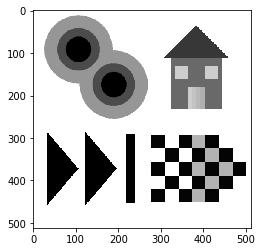

In [180]:
#1.1.1
img = cv2.imread('edgetest_22.png',cv2.IMREAD_GRAYSCALE);
I0 = img.astype(np.float)/255
plt.imshow(I0, cmap='gray') 

In [181]:
#1.1.2
def psnr_function(PSNR):
    Imin=np.min(I0)
    Imax=np.max(I0)
    s=(Imax-Imin)/(np.power(10,(PSNR/20)))
    noise = np.random.normal(0,s,I0.shape)
    I=I0+noise
    #print(s)
    #plt.imshow(I, cmap='gray')
    #plt.show()
    return [I,s]
temp1=psnr_function(20)
temp2=psnr_function(10)
I_20=temp1[0]
I_10=temp2[0]

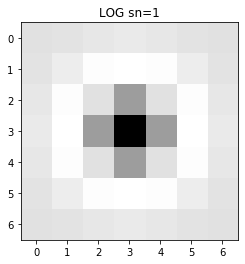

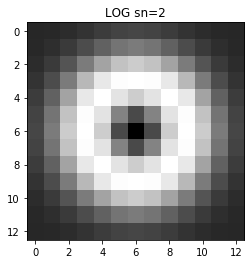

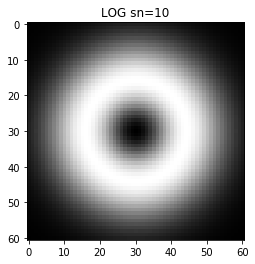

In [182]:
#1.2.1
def gaussian(sn):
    n = int(np.ceil(3*sn)*2+1)
    gaus = cv2.getGaussianKernel(n, sn)
    gaus = gaus @ gaus.transpose()
    return gaus

def LOG(sn):
    n = int(np.ceil(3*sn)*2+1)
    coeff = 1/(2*np.pi*sn**2)
    x = np.linspace(-(n-1)/2, (n-1)/2, n)
    exp_x = np.exp(-(x**2)/(2*(sn**2)))
    laplacian_x = ((x**2)-(sn**2)/(sn**4)) * exp_x

    y = np.linspace(-(n-1)/2, (n-1)/2, n)
    exp_y = np.exp(-(y**2)/(2*(sn**2)))
    laplacian_y = ((y**2)-(sn**2)/(sn**4)) * exp_y

    gaussX, gaussY = np.meshgrid(exp_x, exp_y)
    laplX, laplY = np.meshgrid(laplacian_x, laplacian_y)

    LoG = coeff * ((gaussY*laplX) + (gaussX*laplY))
    return LoG

Gauss = gaussian(1)
LaplacianOfGaussian = LOG(1)
plt.imshow(LaplacianOfGaussian,cmap='gray')
plt.title('LOG sn=1')
plt.show()

Gauss = gaussian(2)
LaplacianOfGaussian = LOG(2)
plt.imshow(LaplacianOfGaussian,cmap='gray')
plt.title('LOG sn=2')
plt.show()

Gauss = gaussian(10)
LaplacianOfGaussian = LOG(10)
plt.imshow(LaplacianOfGaussian,cmap='gray')
plt.title('LOG sn=10')
plt.show()

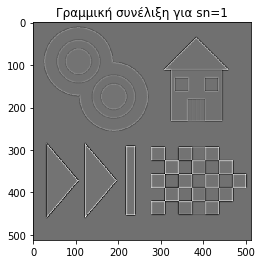

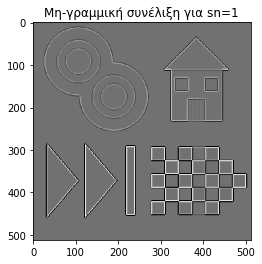

In [183]:
#1.2.2
g=[]
def linear_convolution(image, sn, laplac):
    l1 = cv2.filter2D(image, -1, laplac)
    return l1
    
def non_linear_convolution(image, sn):
    Β = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype=np.uint8)
    dilation = cv2.dilate(image, Β)
    erosion = cv2.erode(image, Β)
    l2 = dilation + erosion - 2*image
    return l2
    
#i
sn=1
laplac=LOG(sn)
L1=linear_convolution(I0, sn, laplac)
plt.imshow(L1, cmap='gray')
plt.title('Γραμμική συνέλιξη για sn=1')
plt.show()

#ii
Iss=gaussian(sn)
Is=cv2.filter2D(I0, -1, Iss)
L2=non_linear_convolution(Is, sn)
plt.imshow(L2, cmap='gray')
plt.title('Μη-γραμμική συνέλιξη για sn=1')
plt.show()

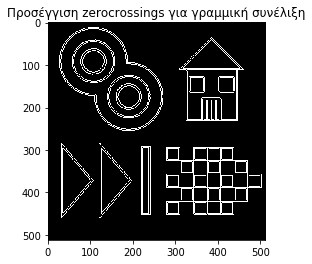

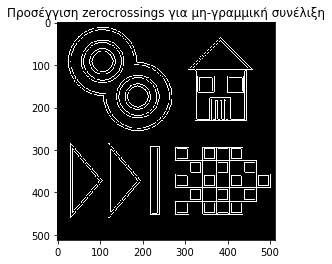

In [184]:
#1.2.3
def algorithm(image):
    _,img = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)
    Β = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype=np.uint8)
    dil = cv2.dilate(img, Β)
    er = cv2.erode(img, Β)
    image_new = dil-er
    return image_new
Y1=algorithm(L1)
Y2=algorithm(L2)
plt.imshow(Y1, cmap='gray')
plt.title('Προσέγγιση zerocrossings για γραμμική συνέλιξη')
plt.show()
plt.imshow(Y2, cmap='gray')
plt.title('Προσέγγιση zerocrossings για μη-γραμμική συνέλιξη')
plt.show()

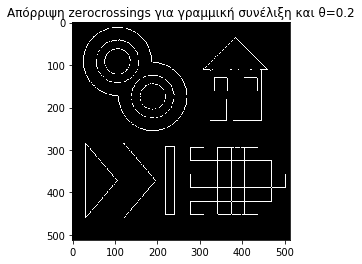

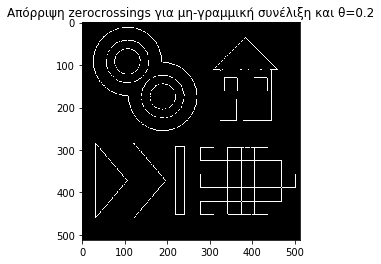

In [185]:
#1.2.4
def no_zerocrossings(Y, Is, theta):    
    grad=np.gradient(Is)
    grad_x=grad[0]
    grad_y=grad[1]
    Grad=np.sqrt(np.square(grad_x)+np.square(grad_y))
    maxgrad=np.amax(Grad)
    edge = np.where((Y == 1) & (Grad > theta*maxgrad), 1, 0)
    #edge = Grad > (theta * Grad.max())
    #edge = ((Y==1) & (Grad > theta * Grad.max()))
    return edge

Iss=gaussian(sn)
Is_20=cv2.filter2D(I_20, -1, Iss)
plot1=no_zerocrossings(Y1,Is_20, 0.2)
plot2=no_zerocrossings(Y2,Is_20, 0.2)
plt.imshow(plot1, cmap='gray')
plt.title('Απόρριψη zerocrossings για γραμμική συνέλιξη και θ=0.2')
plt.show()
plt.imshow(plot2, cmap='gray')
plt.title('Απόρριψη zerocrossings για μη-γραμμική συνέλιξη και θ=0.2')
plt.show()

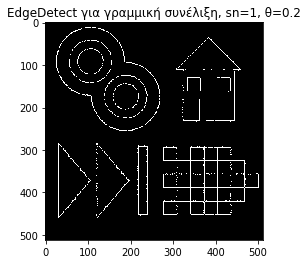

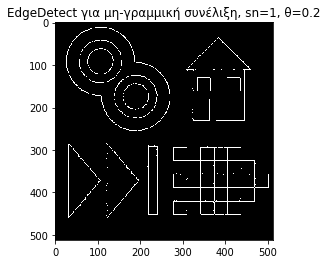

In [186]:
def EdgeDetect(image,sn,theta_edge,linear_or_non):
    Iss=gaussian(sn)
    Is=cv2.filter2D(image, -1, Iss)
    if (linear_or_non==1):
        L=linear_convolution(image,sn,laplac=LOG(sn))
    elif (linear_or_non==0):
        L=non_linear_convolution(Is,sn)
    a=algorithm(L)
    e=no_zerocrossings(a,Is,theta_edge)
    return e

D1=EdgeDetect(I_20,1,0.2,1)
plt.imshow(D1, cmap='gray')
plt.title('EdgeDetect για γραμμική συνέλιξη, sn=1, θ=0.2')
plt.show()

D2=EdgeDetect(I_20,1,0.2,0)
plt.imshow(D2, cmap='gray')
plt.title('EdgeDetect για μη-γραμμική συνέλιξη, sn=1, θ=0.2')
plt.show()

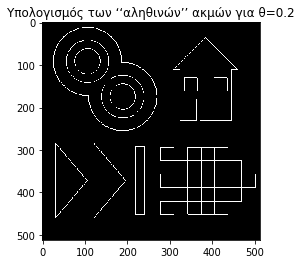

In [187]:
#1.3.1
def real_edges(image,theta):
    Β = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype=np.uint8)
    dil = cv2.dilate(image, Β)
    er = cv2.erode(image, Β)
    image_new = dil-er
    _,img = cv2.threshold(image_new, theta, 1, cv2.THRESH_BINARY)
    return img
T=real_edges(I0,0.2)
plt.imshow(T, cmap='gray')
plt.title('Υπολογισμός των ‘‘αληθινών’’ ακμών για θ=0.2')
plt.show()

In [188]:
#1.3.2
def PR(t,d):
    intersection = (np.array((d == t) & (d == 1)))
    PrTD = (intersection.sum())/(t.sum())
    PrDT = (intersection.sum())/(d.sum())
    C = (PrTD+PrDT)/2
    return C
print(PR(T,D1))
print(PR(T,D2))

0.898818123205691
0.9269415219994197


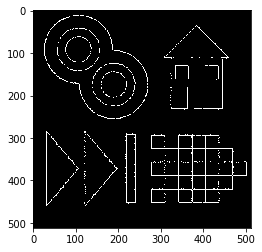

In [189]:
plt.imshow(EdgeDetect(I_20,1,0.2,1), cmap='gray')
plt.show()

0.898818123205691
0.9269415219994197


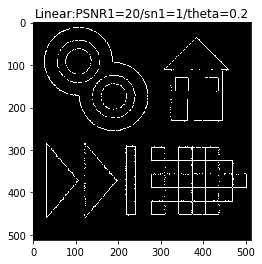

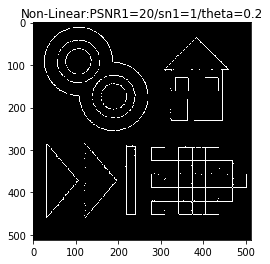

0.5103022407301987
0.5289550796168283


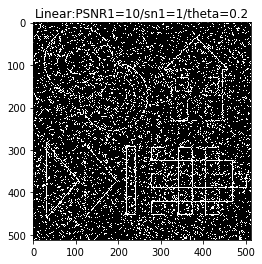

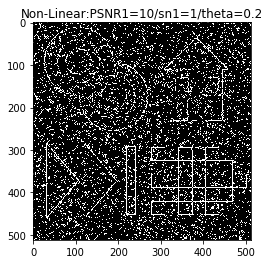

In [190]:
#1.3.3
def exp(image,PSNR,sn,theta_edge):
    D_linear = EdgeDetect(image,sn,theta_edge,1)
    D_non_linear = EdgeDetect(image,sn,theta_edge,0)
    T=real_edges(I0,theta_edge)
    pr_linear=PR(T,D_linear)
    pr_non_linear=PR(T,D_non_linear)
    return D_linear,D_non_linear,pr_linear,pr_non_linear

#a
PSNR1=20
sn1=1
theta=0.2

tem1=exp(I_20,PSNR1,sn1,theta)
plt1_l=tem1[0]
plt1_nl=tem1[1]
plt1_pr_l=tem1[2]
plt1_pr_nl=tem1[3]
print(plt1_pr_l)
print(plt1_pr_nl)
plt.imshow(plt1_l, cmap='gray')
plt.title('Linear:PSNR1=20/sn1=1/theta=0.2')
plt.show()
plt.imshow(plt1_nl, cmap='gray')
plt.title('Non-Linear:PSNR1=20/sn1=1/theta=0.2')
plt.show()

#b
PSNR2=10
sn2=1

tem2=exp(I_10,PSNR2,sn2,theta)
plt2_l=tem2[0]
plt2_nl=tem2[1]
plt2_pr_l=tem2[2]
plt2_pr_nl=tem2[3]
print(plt2_pr_l)
print(plt2_pr_nl)
plt.imshow(plt2_l, cmap='gray')
plt.title('Linear:PSNR1=10/sn1=1/theta=0.2')
plt.show()
plt.imshow(plt2_nl, cmap='gray')
plt.title('Non-Linear:PSNR1=10/sn1=1/theta=0.2')
plt.show()

In [191]:
space_sn = list(np.arange(1, 5.5, 0.5))
space_theta = list(np.arange(0.1, 1, 0.1))
cmax=0
psnr_max=0
sn_max=0
theta_max=0
fla=0
for PSNR in (10,20,10):
    for theta in space_theta:
        for sn in space_sn:
                if(PSNR==20):
                    k=exp(I_20,PSNR,sn,theta)
                elif(PSNR==10):
                    k=exp(I_10,PSNR,sn,theta)
                if(max(k[2],k[3])>cmax):
                    cmax=max(k[2],k[3])
                    sn_max=sn
                    psnr_max=PSNR
                    theta_max=theta
                    if(max(k[2],k[3])==k[2]):
                        fla=1
                    else:
                        fla=0
                print('C_linear={} for PSNR={}, sn ={}, theta={}'.format(k[2], PSNR,sn,theta))
                print('C_non_linear={} for PSNR={}, sn ={}, theta={}'.format(k[3], PSNR,sn,theta))
if (fla==1):                
    print('Maximum C is equal to {} for PSNR={}, sn ={}, theta={} - linear convolution'.format(cmax, psnr_max,sn_max,theta_max))
elif(fla==0):
    print('Maximum C is equal to {} for PSNR={}, sn ={}, theta={} - nonlinear convolution'.format(cmax, psnr_max,sn_max,theta_max))

C_linear=0.47143069166991153 for PSNR=10, sn =1.0, theta=0.1
C_non_linear=0.48596020738350476 for PSNR=10, sn =1.0, theta=0.1
C_linear=0.0006303773957396597 for PSNR=10, sn =1.5, theta=0.1
C_non_linear=0.48711655276134846 for PSNR=10, sn =1.5, theta=0.1
C_linear=0.0 for PSNR=10, sn =2.0, theta=0.1
C_non_linear=0.5071653428405584 for PSNR=10, sn =2.0, theta=0.1
C_linear=0.0 for PSNR=10, sn =2.5, theta=0.1
C_non_linear=0.5523462980382579 for PSNR=10, sn =2.5, theta=0.1
C_linear=0.0 for PSNR=10, sn =3.0, theta=0.1
C_non_linear=0.616054063216464 for PSNR=10, sn =3.0, theta=0.1
C_linear=0.0 for PSNR=10, sn =3.5, theta=0.1
C_non_linear=0.6901323466709505 for PSNR=10, sn =3.5, theta=0.1
C_linear=0.0 for PSNR=10, sn =4.0, theta=0.1
C_non_linear=0.7423351048439455 for PSNR=10, sn =4.0, theta=0.1
C_linear=0.0 for PSNR=10, sn =4.5, theta=0.1
C_non_linear=0.7706127209692495 for PSNR=10, sn =4.5, theta=0.1
C_linear=0.0 for PSNR=10, sn =5.0, theta=0.1
C_non_linear=0.7748649938483998 for PSNR=10, sn 

/home/nonistrati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


C_linear=nan for PSNR=10, sn =4.0, theta=0.2
C_non_linear=0.8204885816345466 for PSNR=10, sn =4.0, theta=0.2
C_linear=nan for PSNR=10, sn =4.5, theta=0.2
C_non_linear=0.8090804686509341 for PSNR=10, sn =4.5, theta=0.2
C_linear=nan for PSNR=10, sn =5.0, theta=0.2
C_non_linear=0.7946359852929705 for PSNR=10, sn =5.0, theta=0.2
C_linear=0.7116154427447878 for PSNR=10, sn =1.0, theta=0.30000000000000004
C_non_linear=0.7426260828066209 for PSNR=10, sn =1.0, theta=0.30000000000000004
C_linear=0.0 for PSNR=10, sn =1.5, theta=0.30000000000000004
C_non_linear=0.8442982069672872 for PSNR=10, sn =1.5, theta=0.30000000000000004
C_linear=0.0 for PSNR=10, sn =2.0, theta=0.30000000000000004
C_non_linear=0.8514293120811058 for PSNR=10, sn =2.0, theta=0.30000000000000004
C_linear=nan for PSNR=10, sn =2.5, theta=0.30000000000000004
C_non_linear=0.8483070608104185 for PSNR=10, sn =2.5, theta=0.30000000000000004
C_linear=nan for PSNR=10, sn =3.0, theta=0.30000000000000004
C_non_linear=0.8414216129906853 f

C_linear=nan for PSNR=20, sn =3.5, theta=0.1
C_non_linear=0.9265174041268477 for PSNR=20, sn =3.5, theta=0.1
C_linear=nan for PSNR=20, sn =4.0, theta=0.1
C_non_linear=0.9176541372297258 for PSNR=20, sn =4.0, theta=0.1
C_linear=nan for PSNR=20, sn =4.5, theta=0.1
C_non_linear=0.9074594918368907 for PSNR=20, sn =4.5, theta=0.1
C_linear=nan for PSNR=20, sn =5.0, theta=0.1
C_non_linear=0.8927663614066152 for PSNR=20, sn =5.0, theta=0.1
C_linear=0.898818123205691 for PSNR=20, sn =1.0, theta=0.2
C_non_linear=0.9269415219994197 for PSNR=20, sn =1.0, theta=0.2
C_linear=0.0 for PSNR=20, sn =1.5, theta=0.2
C_non_linear=0.9437053293996842 for PSNR=20, sn =1.5, theta=0.2
C_linear=nan for PSNR=20, sn =2.0, theta=0.2
C_non_linear=0.9422212469894224 for PSNR=20, sn =2.0, theta=0.2
C_linear=nan for PSNR=20, sn =2.5, theta=0.2
C_non_linear=0.9372237330196825 for PSNR=20, sn =2.5, theta=0.2
C_linear=nan for PSNR=20, sn =3.0, theta=0.2
C_non_linear=0.9301519383605854 for PSNR=20, sn =3.0, theta=0.2
C_lin

C_linear=nan for PSNR=20, sn =3.0, theta=0.9
C_non_linear=0.8643394100555745 for PSNR=20, sn =3.0, theta=0.9
C_linear=nan for PSNR=20, sn =3.5, theta=0.9
C_non_linear=0.8521510555962659 for PSNR=20, sn =3.5, theta=0.9
C_linear=nan for PSNR=20, sn =4.0, theta=0.9
C_non_linear=0.8373059687702116 for PSNR=20, sn =4.0, theta=0.9
C_linear=nan for PSNR=20, sn =4.5, theta=0.9
C_non_linear=0.8188308283111875 for PSNR=20, sn =4.5, theta=0.9
C_linear=nan for PSNR=20, sn =5.0, theta=0.9
C_non_linear=0.8041456882998657 for PSNR=20, sn =5.0, theta=0.9
C_linear=0.47143069166991153 for PSNR=10, sn =1.0, theta=0.1
C_non_linear=0.48596020738350476 for PSNR=10, sn =1.0, theta=0.1
C_linear=0.0006303773957396597 for PSNR=10, sn =1.5, theta=0.1
C_non_linear=0.48711655276134846 for PSNR=10, sn =1.5, theta=0.1
C_linear=0.0 for PSNR=10, sn =2.0, theta=0.1
C_non_linear=0.5071653428405584 for PSNR=10, sn =2.0, theta=0.1
C_linear=0.0 for PSNR=10, sn =2.5, theta=0.1
C_non_linear=0.5523462980382579 for PSNR=10, sn

C_linear=nan for PSNR=10, sn =2.0, theta=0.8
C_non_linear=0.6325887316952097 for PSNR=10, sn =2.0, theta=0.8
C_linear=nan for PSNR=10, sn =2.5, theta=0.8
C_non_linear=0.745240094107238 for PSNR=10, sn =2.5, theta=0.8
C_linear=nan for PSNR=10, sn =3.0, theta=0.8
C_non_linear=0.8205558172636143 for PSNR=10, sn =3.0, theta=0.8
C_linear=nan for PSNR=10, sn =3.5, theta=0.8
C_non_linear=0.8475295433728246 for PSNR=10, sn =3.5, theta=0.8
C_linear=nan for PSNR=10, sn =4.0, theta=0.8
C_non_linear=0.8496434685032834 for PSNR=10, sn =4.0, theta=0.8
C_linear=nan for PSNR=10, sn =4.5, theta=0.8
C_non_linear=0.8437079085867929 for PSNR=10, sn =4.5, theta=0.8
C_linear=nan for PSNR=10, sn =5.0, theta=0.8
C_non_linear=0.8283992439045111 for PSNR=10, sn =5.0, theta=0.8
C_linear=0.5012658227848101 for PSNR=10, sn =1.0, theta=0.9
C_non_linear=0.5012658227848101 for PSNR=10, sn =1.0, theta=0.9
C_linear=nan for PSNR=10, sn =1.5, theta=0.9
C_non_linear=0.5023206751054853 for PSNR=10, sn =1.5, theta=0.9
C_lin

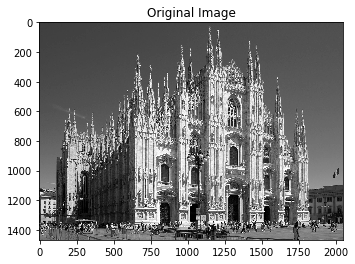

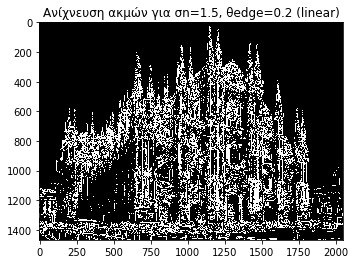

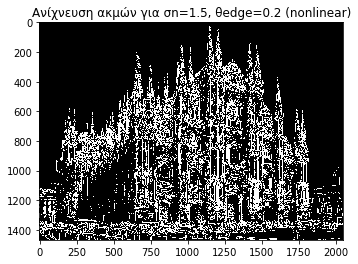

In [192]:
#1.4.1
img_duomo = cv2.imread('duomo_edges.jpg',cv2.IMREAD_GRAYSCALE);
Id = img_duomo.astype(np.float)/255
plt.imshow(Id, cmap='gray')
plt.title('Original Image')
plt.show()

sn=1
theta_edge=0.1
ed_linear=EdgeDetect(Id,sn,theta_edge,1) #linear
plt.imshow(ed_linear, cmap='gray')
plt.title('Ανίχνευση ακμών για σn=1.5, θedge=0.2 (linear)')
plt.show()
ed_nonlinear=EdgeDetect(Id,sn,theta_edge,0) #non_linear
plt.imshow(ed_nonlinear, cmap='gray')
plt.title('Ανίχνευση ακμών για σn=1.5, θedge=0.2 (nonlinear)')
plt.show()

In [193]:
#1.1.2
def psnr_functionn(PSNR):
    Imin=np.min(Id)
    Imax=np.max(Id)
    s=(Imax-Imin)/(np.power(10,(PSNR/20)))
    noise = np.random.normal(0,s,Id.shape)
    I=Id+noise
    #print(s)
    #plt.imshow(I, cmap='gray')
    #plt.show()
    return [I,s]
temp11=psnr_functionn(20)
temp22=psnr_functionn(10)
I_20=temp11[0]
I_10=temp22[0]

def exp2(image,PSNR,sn,theta_edge):
    D_linear = EdgeDetect(image,sn,theta_edge,1)
    D_non_linear = EdgeDetect(image,sn,theta_edge,0)
    T=real_edges(Id,theta_edge)
    pr_linear=PR(T,D_linear)
    pr_non_linear=PR(T,D_non_linear)
    return D_linear,D_non_linear,pr_linear,pr_non_linear

In [194]:
space_sn = list(np.arange(1, 5.5, 0.5))
space_theta = list(np.arange(0.1, 1, 0.1))
cmax=0
psnr_max=0
sn_max=0
theta_max=0
fla=0
for PSNR in (10,20,10):
    for theta in space_theta:
        for sn in space_sn:
                if(PSNR==20):
                    k=exp2(I_20,PSNR,sn,theta)
                elif(PSNR==10):
                    k=exp2(I_10,PSNR,sn,theta)
                if(max(k[2],k[3])>cmax):
                    cmax=max(k[2],k[3])
                    sn_max=sn
                    psnr_max=PSNR
                    theta_max=theta
                    if(max(k[2],k[3])==k[2]):
                        fla=1
                    else:
                        fla=0
                print('C_linear={} for PSNR={}, sn ={}, theta={}'.format(k[2], PSNR,sn,theta))
                print('C_non_linear={} for PSNR={}, sn ={}, theta={}'.format(k[3], PSNR,sn,theta))
if (fla==1):                
    print('Maximum C is equal to {} for PSNR={}, sn ={}, theta={} - linear convolution'.format(cmax, psnr_max,sn_max,theta_max))
elif(fla==0):
    print('Maximum C is equal to {} for PSNR={}, sn ={}, theta={} - nonlinear convolution'.format(cmax, psnr_max,sn_max,theta_max))

C_linear=0.5379782792895982 for PSNR=10, sn =1.0, theta=0.1
C_non_linear=0.5377360578970959 for PSNR=10, sn =1.0, theta=0.1
C_linear=0.028924597400027986 for PSNR=10, sn =1.5, theta=0.1
C_non_linear=0.4857925379902895 for PSNR=10, sn =1.5, theta=0.1
C_linear=0.01425188014837078 for PSNR=10, sn =2.0, theta=0.1
C_non_linear=0.45784796779266135 for PSNR=10, sn =2.0, theta=0.1
C_linear=0.00786259288193488 for PSNR=10, sn =2.5, theta=0.1
C_non_linear=0.4491660528921561 for PSNR=10, sn =2.5, theta=0.1
C_linear=0.0069970913221508255 for PSNR=10, sn =3.0, theta=0.1
C_non_linear=0.44904470340565683 for PSNR=10, sn =3.0, theta=0.1
C_linear=0.015738860604552547 for PSNR=10, sn =3.5, theta=0.1
C_non_linear=0.44607245933710166 for PSNR=10, sn =3.5, theta=0.1
C_linear=0.0 for PSNR=10, sn =4.0, theta=0.1
C_non_linear=0.4453664070501442 for PSNR=10, sn =4.0, theta=0.1
C_linear=0.0 for PSNR=10, sn =4.5, theta=0.1
C_non_linear=0.44217607221151506 for PSNR=10, sn =4.5, theta=0.1
C_linear=0.0 for PSNR=10,

/home/nonistrati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


C_linear=nan for PSNR=10, sn =3.5, theta=0.2
C_non_linear=0.4378069625139679 for PSNR=10, sn =3.5, theta=0.2
C_linear=nan for PSNR=10, sn =4.0, theta=0.2
C_non_linear=0.40333120097697256 for PSNR=10, sn =4.0, theta=0.2
C_linear=nan for PSNR=10, sn =4.5, theta=0.2
C_non_linear=0.3707822077693052 for PSNR=10, sn =4.5, theta=0.2
C_linear=nan for PSNR=10, sn =5.0, theta=0.2
C_non_linear=0.34670036706830887 for PSNR=10, sn =5.0, theta=0.2
C_linear=0.4569816487587065 for PSNR=10, sn =1.0, theta=0.30000000000000004
C_non_linear=0.4647877954277443 for PSNR=10, sn =1.0, theta=0.30000000000000004
C_linear=0.010001308626465661 for PSNR=10, sn =1.5, theta=0.30000000000000004
C_non_linear=0.49328595237757733 for PSNR=10, sn =1.5, theta=0.30000000000000004
C_linear=0.0 for PSNR=10, sn =2.0, theta=0.30000000000000004
C_non_linear=0.4632424172145809 for PSNR=10, sn =2.0, theta=0.30000000000000004
C_linear=0.0 for PSNR=10, sn =2.5, theta=0.30000000000000004
C_non_linear=0.4203591184569548 for PSNR=10, 

C_linear=0.0 for PSNR=20, sn =2.0, theta=0.1
C_non_linear=0.6468808953774015 for PSNR=20, sn =2.0, theta=0.1
C_linear=nan for PSNR=20, sn =2.5, theta=0.1
C_non_linear=0.6114973225076289 for PSNR=20, sn =2.5, theta=0.1
C_linear=nan for PSNR=20, sn =3.0, theta=0.1
C_non_linear=0.5767859814268418 for PSNR=20, sn =3.0, theta=0.1
C_linear=nan for PSNR=20, sn =3.5, theta=0.1
C_non_linear=0.5458371713926217 for PSNR=20, sn =3.5, theta=0.1
C_linear=nan for PSNR=20, sn =4.0, theta=0.1
C_non_linear=0.5175317664990973 for PSNR=20, sn =4.0, theta=0.1
C_linear=nan for PSNR=20, sn =4.5, theta=0.1
C_non_linear=0.49023508608738026 for PSNR=20, sn =4.5, theta=0.1
C_linear=nan for PSNR=20, sn =5.0, theta=0.1
C_non_linear=0.4684185754774407 for PSNR=20, sn =5.0, theta=0.1
C_linear=0.7303119477944529 for PSNR=20, sn =1.0, theta=0.2
C_non_linear=0.7385760199744862 for PSNR=20, sn =1.0, theta=0.2
C_linear=nan for PSNR=20, sn =1.5, theta=0.2
C_non_linear=0.6753683575669482 for PSNR=20, sn =1.5, theta=0.2
C_l

C_linear=nan for PSNR=20, sn =5.0, theta=0.8
C_non_linear=0.13410919302312743 for PSNR=20, sn =5.0, theta=0.8
C_linear=0.3663570342847492 for PSNR=20, sn =1.0, theta=0.9
C_non_linear=0.3663570342847492 for PSNR=20, sn =1.0, theta=0.9
C_linear=nan for PSNR=20, sn =1.5, theta=0.9
C_non_linear=0.21872640935102886 for PSNR=20, sn =1.5, theta=0.9
C_linear=nan for PSNR=20, sn =2.0, theta=0.9
C_non_linear=0.1410756782484531 for PSNR=20, sn =2.0, theta=0.9
C_linear=nan for PSNR=20, sn =2.5, theta=0.9
C_non_linear=0.08209424083769634 for PSNR=20, sn =2.5, theta=0.9
C_linear=nan for PSNR=20, sn =3.0, theta=0.9
C_non_linear=0.050165493169645546 for PSNR=20, sn =3.0, theta=0.9
C_linear=nan for PSNR=20, sn =3.5, theta=0.9
C_non_linear=0.03079670441170502 for PSNR=20, sn =3.5, theta=0.9
C_linear=nan for PSNR=20, sn =4.0, theta=0.9
C_non_linear=0.0 for PSNR=20, sn =4.0, theta=0.9
C_linear=nan for PSNR=20, sn =4.5, theta=0.9
C_non_linear=0.0 for PSNR=20, sn =4.5, theta=0.9
C_linear=nan for PSNR=20, sn

C_linear=nan for PSNR=10, sn =4.0, theta=0.7000000000000001
C_non_linear=0.1492675919876408 for PSNR=10, sn =4.0, theta=0.7000000000000001
C_linear=nan for PSNR=10, sn =4.5, theta=0.7000000000000001
C_non_linear=0.14365498184797318 for PSNR=10, sn =4.5, theta=0.7000000000000001
C_linear=nan for PSNR=10, sn =5.0, theta=0.7000000000000001
C_non_linear=0.13342916220667284 for PSNR=10, sn =5.0, theta=0.7000000000000001
C_linear=0.26068248272195643 for PSNR=10, sn =1.0, theta=0.8
C_non_linear=0.26068248272195643 for PSNR=10, sn =1.0, theta=0.8
C_linear=nan for PSNR=10, sn =1.5, theta=0.8
C_non_linear=0.2705477392977393 for PSNR=10, sn =1.5, theta=0.8
C_linear=nan for PSNR=10, sn =2.0, theta=0.8
C_non_linear=0.17843550755784798 for PSNR=10, sn =2.0, theta=0.8
C_linear=nan for PSNR=10, sn =2.5, theta=0.8
C_non_linear=0.13141835016835016 for PSNR=10, sn =2.5, theta=0.8
C_linear=nan for PSNR=10, sn =3.0, theta=0.8
C_non_linear=0.08368221690590111 for PSNR=10, sn =3.0, theta=0.8
C_linear=nan for

0.7303119477944529
0.7385760199744862


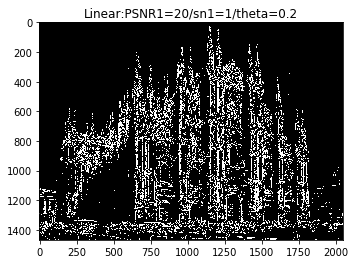

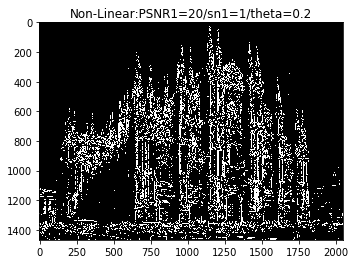

0.46475882479469854
0.47186184596597147


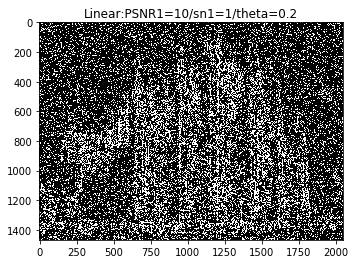

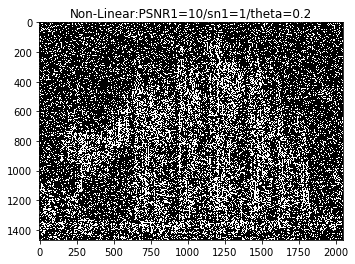

In [195]:
PSNR1=20
sn1=1
theta=0.2

tem1=exp2(I_20,PSNR1,sn1,theta)
plt1_l=tem1[0]
plt1_nl=tem1[1]
plt1_pr_l=tem1[2]
plt1_pr_nl=tem1[3]
print(plt1_pr_l)
print(plt1_pr_nl)
plt.imshow(plt1_l, cmap='gray')
plt.title('Linear:PSNR1=20/sn1=1/theta=0.2')
plt.show()
plt.imshow(plt1_nl, cmap='gray')
plt.title('Non-Linear:PSNR1=20/sn1=1/theta=0.2')
plt.show()

#b
PSNR2=10
sn2=1

tem2=exp2(I_10,PSNR2,sn2,theta)
plt2_l=tem2[0]
plt2_nl=tem2[1]
plt2_pr_l=tem2[2]
plt2_pr_nl=tem2[3]
print(plt2_pr_l)
print(plt2_pr_nl)
plt.imshow(plt2_l, cmap='gray')
plt.title('Linear:PSNR1=10/sn1=1/theta=0.2')
plt.show()
plt.imshow(plt2_nl, cmap='gray')
plt.title('Non-Linear:PSNR1=10/sn1=1/theta=0.2')
plt.show()